In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import sys
sys.path.append("scripts/")
import siegel_setup as setup
import tqdm
from netrep.metrics import LinearMetric
import netrep_helpers as nh
import pandas as pd
import scipy.stats as sts
import imp
from joblib import Parallel, delayed

from mord import LogisticAT
np.int = int

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from scikits.bootstrap import ci
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from scipy.spatial import procrustes 


/var/folders/6w/snfd5vc50jb775fq8364m1d80000gn/T/ipykernel_93960/4273495888.py:13: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


## global parameters

In [2]:
M=10 # manifold size
sample_N = 80 # number of neurons to subsample
n_samples= 100 #set to 100 for stable results # number of subsamples to draw

## load data


In [3]:
rex = np.array([ 4,  5,  9, 10, 12, 13, 15, 16, 35, 37, 38, 39, 41, 42, 43, 44])
paula = np.array([ 0,  1,  2,  3,  6,  7,  8, 11, 14, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 40])

rex_idx = [0,2,4,6]
paula_idx = [1,3,5,7,8,9,10]

f=open("data/Siegel_10_folds_avg_stim_netrep.pkl","rb")
all_averaged_folds=pickle.load(f)
f.close()


## 

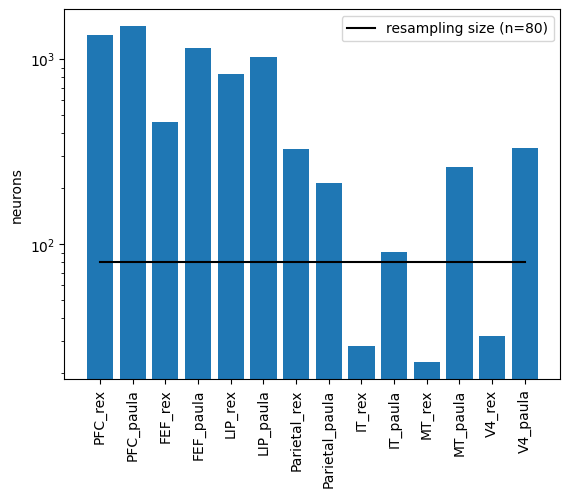

In [4]:
plt.bar(list(all_averaged_folds[0][0].keys()),[np.shape(a)[1] for a in all_averaged_folds[0][0].values()])
plt.xticks(rotation=90)
plt.ylabel("neurons")
plt.yscale('log')
plt.plot(list(all_averaged_folds[0][0].keys()),np.ones(14)*80,"k",label="resampling size (n=80)")
plt.legend()


bad_areas = ["IT_rex", "MT_rex","V4_rex"]

## analyses done with folds as another area

In [10]:


all_dists_det = np.zeros((n_samples,10,7*2*2,7*2*2))

# do many resample repetitions
for sample in tqdm.trange(n_samples):

    # run over all independent halves
    for fold1 in range(len(all_averaged_folds)):
        averaged_train, averaged_test =  all_averaged_folds[fold1]
   
        # combine halves
        averaged_area = {}
        for key in averaged_train.keys():
            averaged_area[key+"_A"] = averaged_train[key]
            averaged_area[key+"_B"] = averaged_test[key]

        for a1,area in enumerate(averaged_area.keys()):

            # subsample 80 neurons to match neurons across areas
            idx = np.array(range(averaged_area[area].shape[1]))
            np.random.shuffle(idx)
            area_train = averaged_area[area][:,idx[:sample_N]]

            # use only first m components
            X_1, _ = nh.get_low_d(area_train,area_train,m=M,zscore=True)

            for a2 in range(a1,len(averaged_area.keys())):

                area2 = list(averaged_area.keys())[a2]
                # subsample sample_N neurons to match neurons across areas
                idx = np.array(range(averaged_area[area2].shape[1]))
                np.random.shuffle(idx)
                area_train = averaged_area[area2][:,idx[:sample_N]]

                # use only first m components
                X_2, _ = nh.get_low_d(area_train,area_train,m=M,zscore=True)

                metric = LinearMetric(alpha=1,score_method="euclidean")
                dist = metric.fit_score(X_1,X_2)

                all_dists_det[sample,fold1,a1,a2] = all_dists_det[sample,fold1,a2,a1] = dist

100%|██████████| 100/100 [42:47<00:00, 25.68s/it]  


In [11]:
averaged_area.keys()

dict_keys(['PFC_rex_A', 'PFC_rex_B', 'PFC_paula_A', 'PFC_paula_B', 'FEF_rex_A', 'FEF_rex_B', 'FEF_paula_A', 'FEF_paula_B', 'LIP_rex_A', 'LIP_rex_B', 'LIP_paula_A', 'LIP_paula_B', 'Parietal_rex_A', 'Parietal_rex_B', 'Parietal_paula_A', 'Parietal_paula_B', 'IT_rex_A', 'IT_rex_B', 'IT_paula_A', 'IT_paula_B', 'MT_rex_A', 'MT_rex_B', 'MT_paula_A', 'MT_paula_B', 'V4_rex_A', 'V4_rex_B', 'V4_paula_A', 'V4_paula_B'])

([], [])

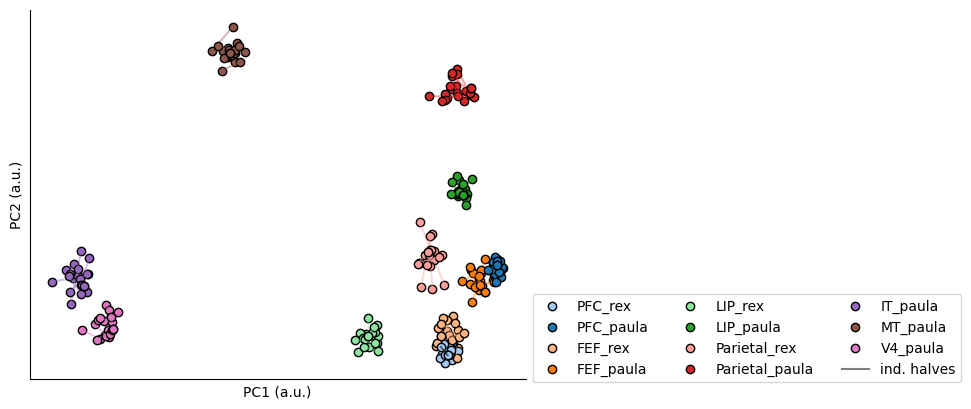

In [12]:
# ignoring areas with low N from analyses

# average across all resamples -> 10 folds x 28 regions x 28 regions (28 regions is 7 X 2 subjects X 2 folds)
# 28 index goes like: 'PFC_rex_A', 'PFC_rex_B', 'PFC_paula_A', 'PFC_paula_B', 'FEF_rex_A', etc
all_dists_det_ = np.mean(all_dists_det,0)

def is_bad_area(key, bad_areas):
    flag = False

    for area in bad_areas:
       flag = flag or (area in key)

    return flag

idx = [not is_bad_area(k,bad_areas) for k in averaged_area.keys()]

all_dists_clean = all_dists_det_[:,idx][:,:,idx]
areas_clean = np.array(list(averaged_area.keys()))[idx]

[np.fill_diagonal(d,0) for d in all_dists_clean]

# build palletes for nice plotting 
palette_paula= np.array(sns.color_palette(None, 7))
palette_rex= np.array(sns.color_palette('pastel', 7))

palette_key = {}
for area_key in areas_clean:
    area = area_key.split("_")[0]

    i = np.where([area in s for s in setup.areas])[0][0]

    if "rex" in area_key:
        color = palette_rex[i]
    else:
        color = palette_paula[i]

    palette_key[area_key] = color


# expand dimensionality to avoid distorcions and then PCA it for plotting 
dist_mds = [MDS(n_components=25,dissimilarity="precomputed",normalized_stress=False).fit_transform(dist) for dist in all_dists_clean]
dist_pca = [PCA(n_components=9,svd_solver='full').fit_transform(dist) for dist in dist_mds]


for dist_low in dist_pca:
    # alig low dim representations to first one (to avoid PCA rotation invariances)
    _,dist_low,_ = procrustes(dist_pca[0],dist_low )

    for c,i in enumerate(range(0,len(areas_clean),2)):
        color = palette_key[areas_clean[i]]
        

        plt.plot(dist_low[i:i+2,0],dist_low[i:i+2,1],"o",color="black",markerfacecolor=color)
        plt.plot(dist_low[i:i+2,0],dist_low[i:i+2,1],"-",color=color,alpha=0.4)

# plot just 1 to get labels
[plt.plot(dist_low[i,0],dist_low[i,1],"o",color="black",markerfacecolor=palette_key[areas_clean[i]],label=areas_clean[i].split("_A")[0]) for i in range(0,len(areas_clean),2)]
plt.plot(dist_low[:2,0],dist_low[:2,1],"-",color="black",markerfacecolor=palette_key[areas_clean[0]],label="ind. halves",alpha=0.5)
plt.legend(bbox_to_anchor=(1,0.25),ncols=3)

sns.despine()
plt.xlabel("PC1 (a.u.)")
plt.ylabel("PC2 (a.u.)")

plt.xticks([])
plt.yticks([])

# plt.savefig("../figures/2PCs_dists.svg")

In [14]:

# as mentioned above, the index goes like 'PFC_rex_A', 'PFC_rex_B', 'PFC_paula_A', 'PFC_paula_B', 'FEF_rex_A', etc
# so we can get independent folds by taking every other index
idx_fold_A = np.arange(0,len(areas_clean),2)
idx_fold_B = np.arange(1,len(areas_clean),2)

# map areas names to numbers
area_to_num = {area: i for i,area in enumerate(setup.areas)}


def pred(model,data,y,score):

    # use for shuffle control
    idx_fold_B_s = idx_fold_B.copy()
    idx_fold_A_s = idx_fold_A.copy()

    # fit data on 1 fold
    model.fit(data[idx_fold_A], y[idx_fold_A])
   
    # predict on the other fold
    preds = model.predict(data[idx_fold_B])
    c=score(y[idx_fold_B],preds)
   
    # shuffle baseline for p-values
    all_c_s = []
    for _ in range(100):
        np.random.shuffle(idx_fold_B_s)
        np.random.shuffle(idx_fold_A_s)

        model.fit(data[idx_fold_A], y[idx_fold_A_s])
        c_s=score(model.predict(data[idx_fold_B]),y[idx_fold_B_s])
        all_c_s.append(c_s)

    return (c,all_c_s,preds,model.coef_)

scores = []
coefs = []
shuffles_pred = []
all_preds = []

y_monkey =  np.array([s.split("_")[1] == "rex" for s in areas_clean],dtype='int')
y_area =  np.array([area_to_num[s.split("_")[0]] for s in areas_clean],dtype='int')

model = LogisticAT()

for data in dist_pca:
    c_area,c_s_area,preds_area,coef_area,= pred(model,data,y_area,mean_squared_error)
    c_monkey,c_s_monkey,preds_monkey,coef_monkey = pred(model,data,y_monkey,accuracy_score)

    scores.append([c_area,c_monkey])
    coefs.append([coef_area,coef_monkey])
    shuffles_pred.append([c_s_area,c_s_monkey])
    all_preds.append(preds_area)

scores = np.array(scores)
coefs = np.array(coefs)
shuffles_pred = np.array(shuffles_pred)


Text(0.5, 1.0, 'prediction\n(ordinal regression)')

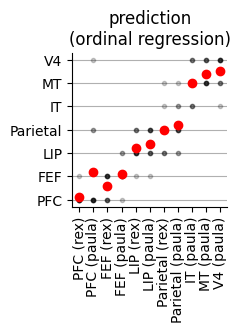

In [15]:
plt.figure(figsize=(2,2))
xlabels = ["%s (%s)" % tuple(np.array(a.split("_"))[[0,1]]) for a in areas_clean[idx_fold_A]]
plt.plot(xlabels,np.array(all_preds).T,"k.",alpha=0.2)
plt.plot(xlabels,np.mean(all_preds,0),"ro")

plt.xticks(rotation=90)
plt.yticks(range(7),setup.areas)
plt.grid(axis='y')
sns.despine()
plt.title("prediction\n(ordinal regression)")
# plt.savefig("../figures/prediction_plot.svg")

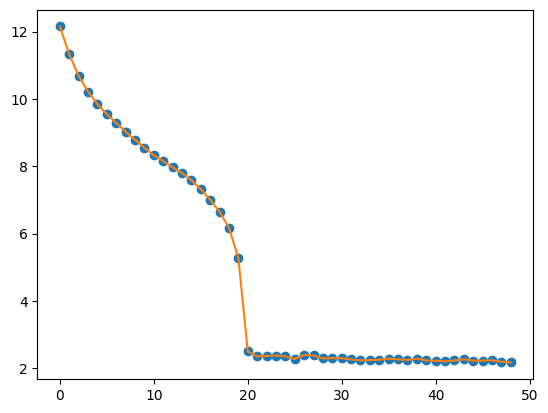

In [16]:
stress = [MDS(n_components=i,dissimilarity="precomputed",normalized_stress=False).fit(all_dists_clean[0]).stress_ for i in range(1,50)]

plt.plot(np.log(stress),"o")
plt.plot(np.log(stress))



In [17]:
d = [np.mean(shuffles_pred[f][0]<scores[f][0])/2 for f in range(10)]
print(d)

d = [np.mean(shuffles_pred[f][1]>scores[f][1])/2 for f in range(10)]
print(d)

[0.035, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


([], [])

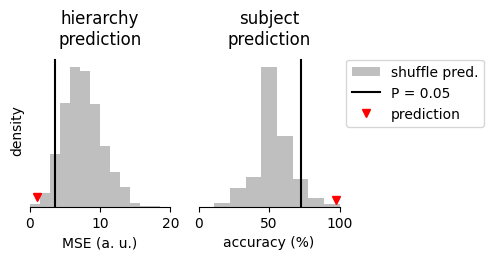

In [18]:
p_hierch = np.mean(np.mean(scores,0)[0] > np.concatenate(shuffles_pred[:,0]))
p_moneky = np.mean(np.mean(scores,0)[1] < np.concatenate(shuffles_pred[:,1]))


plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.title("hierarchy\nprediction")
shuffle_data = np.concatenate(shuffles_pred[:,0])
plt.hist(shuffle_data,bins=np.linspace(0,20,15),alpha=0.5,color="gray",density=True,label="shuffle pred.")
plt.plot(np.mean(scores,0)[0],0.01,"rv")
plt.plot(np.percentile(shuffle_data,[5,5]),plt.ylim(),"k",label="P = 0.05")
plt.xlabel("MSE (a. u.)")
plt.xlim(0,20)
sns.despine(left=True)
plt.yticks([])
plt.ylabel("density")

plt.subplot(1,2,2)
plt.title("subject\nprediction")
shuffle_data = np.concatenate(shuffles_pred[:,1])
plt.hist(shuffle_data,bins=np.linspace(0,1,10),alpha=0.5,color="gray",density=True,label="shuffle pred.")
plt.plot(np.percentile(shuffle_data,[95,95]),plt.ylim(),"k",label="P = 0.05")
plt.plot(np.mean(scores,0)[1],0.2,"rv",label="prediction")
plt.legend(bbox_to_anchor=(1,1))
plt.xticks([0,0.5,1],[0,50,100])
plt.xlim(0,1)
plt.xlabel("accuracy (%)")

sns.despine(left=True)
plt.yticks([])

# plt.savefig("../figures/prediction_hierarchy_subject.svg")

In [19]:

all_dist_fold_A = all_dists_clean[:,idx_fold_A,:][:,:,idx_fold_A].copy()
all_dist_fold_B = all_dists_clean[:,idx_fold_B,:][:,:,idx_fold_B].copy()
all_dist_fold_AB = all_dists_clean[:,idx_fold_A,:][:,:,idx_fold_B].copy()


# ignore self distances
[np.fill_diagonal(dist,np.nan) for dist in all_dist_fold_A]
[np.fill_diagonal(dist,np.nan) for dist in all_dist_fold_B]
[np.fill_diagonal(dist,np.nan) for dist in all_dist_fold_AB]

[None, None, None, None, None, None, None, None, None, None]

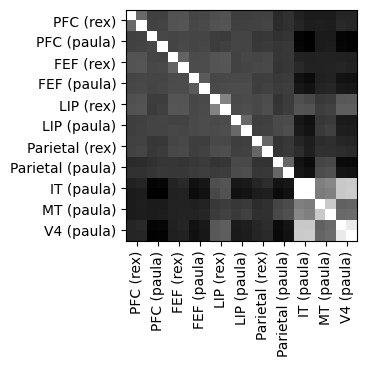

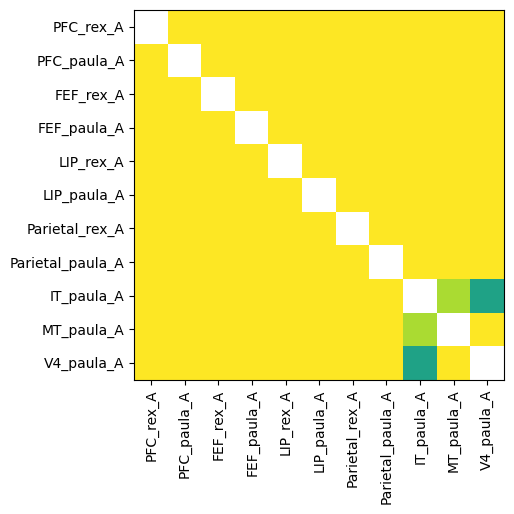

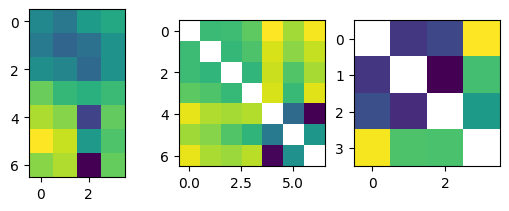

In [20]:
plt.figure(figsize=(3,3))
dists = np.mean(all_dists_clean,0)
np.fill_diagonal(dists,np.nan)
xlabels = ["%s (%s)" % tuple(np.array(a.split("_"))[[0,1]]) for a in areas_clean[idx_fold_A]]
plt.imshow(dists,cmap="Greys")
plt.xticks(np.arange(0.5,22,2),xlabels,rotation=90)
plt.yticks(np.arange(0.5,22,2),xlabels)
# plt.colorbar(fraction=0.046, pad=0.04)

# plt.savefig("../figures/distmat.svg")
plt.figure()

plt.imshow(np.mean(all_dist_fold_A,0),vmax=50,vmin=34)
plt.xticks(range(len(idx_fold_A )),areas_clean[idx_fold_A],rotation=90)
plt.yticks(range(len(idx_fold_A )),areas_clean[idx_fold_A])

plt.figure()

plt.subplot(2,3,2)
plt.imshow(np.mean(all_dist_fold_AB,0)[:,paula_idx][paula_idx,:])

plt.subplot(2,3,3)
plt.imshow(np.mean(all_dist_fold_AB,0)[:,rex_idx][rex_idx,:])


plt.subplot(2,3,1)

plt.imshow(np.mean(all_dist_fold_AB,0)[paula_idx,:][:,rex_idx])
# plt.xticks(range(len(idx_fold_A[rex_idx])),areas_clean[idx_fold_A[rex_idx]],rotation=90)
# plt.yticks(range(len(idx_fold_A )),areas_clean[idx_fold_A])

# plt.tight_layout()

## sumarize self distances

In [21]:
all_intra_fold = []
for di,d in enumerate(all_dists_clean):
    deltas = []
    for ii,i in enumerate(idx_fold_A):
        intra_fold = d[i,i+1]
        delta_A = all_dist_fold_A[di,ii] - intra_fold
        delta_B = all_dist_fold_A[di,ii] - intra_fold
        deltas.append(delta_A)
        deltas.append(delta_B)

    all_intra_fold.append(np.concatenate(deltas))

Text(0, 0.5, 'density')

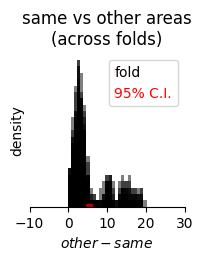

In [22]:
plt.figure(figsize=(2,2))
plt.title("same vs other areas\n(across folds)")

cis = [ci(fold,statfunction=np.nanmean) for fold in all_intra_fold]

[plt.hist(fold,np.linspace(-10,30,50),color="black",alpha=0.5) for fold in all_intra_fold]
[plt.fill_between(ci,[1,1],alpha=0.1,color="red") for ci in cis]

plt.xlim(-10,30)
plt.xticks([-10,0,10,20,30])

plt.xlabel(r"$other - same$")
leg = plt.legend(labels=["fold","95% C.I."],labelcolor=["black","red"],handlelength=0, handletextpad=0)
sns.despine(left=True)
plt.yticks([])
plt.ylabel("density")


# plt.savefig("../figures/dist_folds.svg")

## summarize across monkey,same area distance

In [23]:

all_dists = []
all_s = []
for f,fold_A in enumerate(all_dist_fold_A):
    
    fold_B = all_dist_fold_B[f]
    all_folds = []

    for fold in [fold_A,fold_B]:
        cross_dist = fold[:,rex_idx][paula_idx,:]

        across_monkey_self = np.diagonal(cross_dist)

        # use only lower triangle - only across monkey comparison
        cross_dist = np.tril(cross_dist)
        cross_dist[cross_dist==0] = np.nan

        # difference between same area and all others
        cross_rand_dist = cross_dist - across_monkey_self

        # ignore same
        cross_rand_dist[cross_rand_dist==0]=np.nan

        all_folds.append(np.concatenate(cross_rand_dist))
    
    all_s.append(ci(np.concatenate(all_folds),statfunction=np.nanmean))

    all_dists.append(np.concatenate(all_folds))

all_dists = np.array(all_dists)
all_s

[array([0.55079482, 1.15989277]),
 array([0.50394765, 1.21824514]),
 array([0.72192697, 1.3864688 ]),
 array([0.64276369, 1.24778248]),
 array([0.60108854, 1.21825125]),
 array([0.55793986, 1.16580533]),
 array([0.59894571, 1.27917219]),
 array([0.72167947, 1.31105977]),
 array([0.59177825, 1.29014841]),
 array([0.68701491, 1.28939946])]

Text(0, 0.5, 'density')

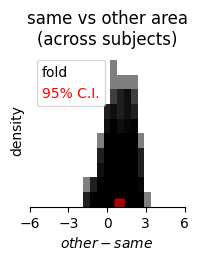

In [24]:
plt.figure(figsize=(2,2))
plt.title("same vs other area\n(across subjects)")
[plt.hist(d,bins=np.linspace(-5,5,20),color="black",alpha=0.5) for d in all_dists]
[plt.fill_between(cis,[0.5,0.5],alpha=0.1,color="red") for cis in all_s]

plt.xlabel(r"$other - same$")
leg = plt.legend(labels=["fold","95% C.I."],labelcolor=["black","red"],handlelength=0, handletextpad=0)
sns.despine(left=True)
plt.xlim(-6,6)
plt.xticks([-6,-3,0,3,6])

plt.yticks([])
plt.ylabel("density")

# plt.savefig("../figures/delta_dist_paired.svg")